In [1]:
library(tidyverse)
library(glue)
library(here)
library(furrr)
library(lemon)
library(cowplot)
    
devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

here() starts at /mnt/expressions/mp/ychr
Loading required package: future

Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading ychr


In [2]:
get_lengths <- function(bam) { 
    lengths <- paste("samtools view ", bam, " | awk '{print length($10)}'") %>%
        pipe %>%
        scan
    name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "") %>% fix_name
    regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
    
    tibble(name = name, regions = regions, length = lengths)
}

In [3]:
length_df <-
    list.files(here("data/bam"), ".bam$", full.names = TRUE) %>%
    str_subset("full_den4|full_den8|full_mez2[^_]|full_spy1|lippold_elsidron2") %>%
    future_map_dfr(get_lengths)

In [4]:
summary_df <- length_df %>%
    group_by(name) %>%
    summarise(mean = mean(length), median = median(length)) %>%
    arrange(mean)

In [5]:
summary_df

name,mean,median
<chr>,<dbl>,<dbl>
Denisova 8,44.77619,42
Spy 1,51.18383,47
Denisova 4,53.89470,49
Mezmaiskaya 2,54.09177,49
El Sidrón 1253,55.33982,51


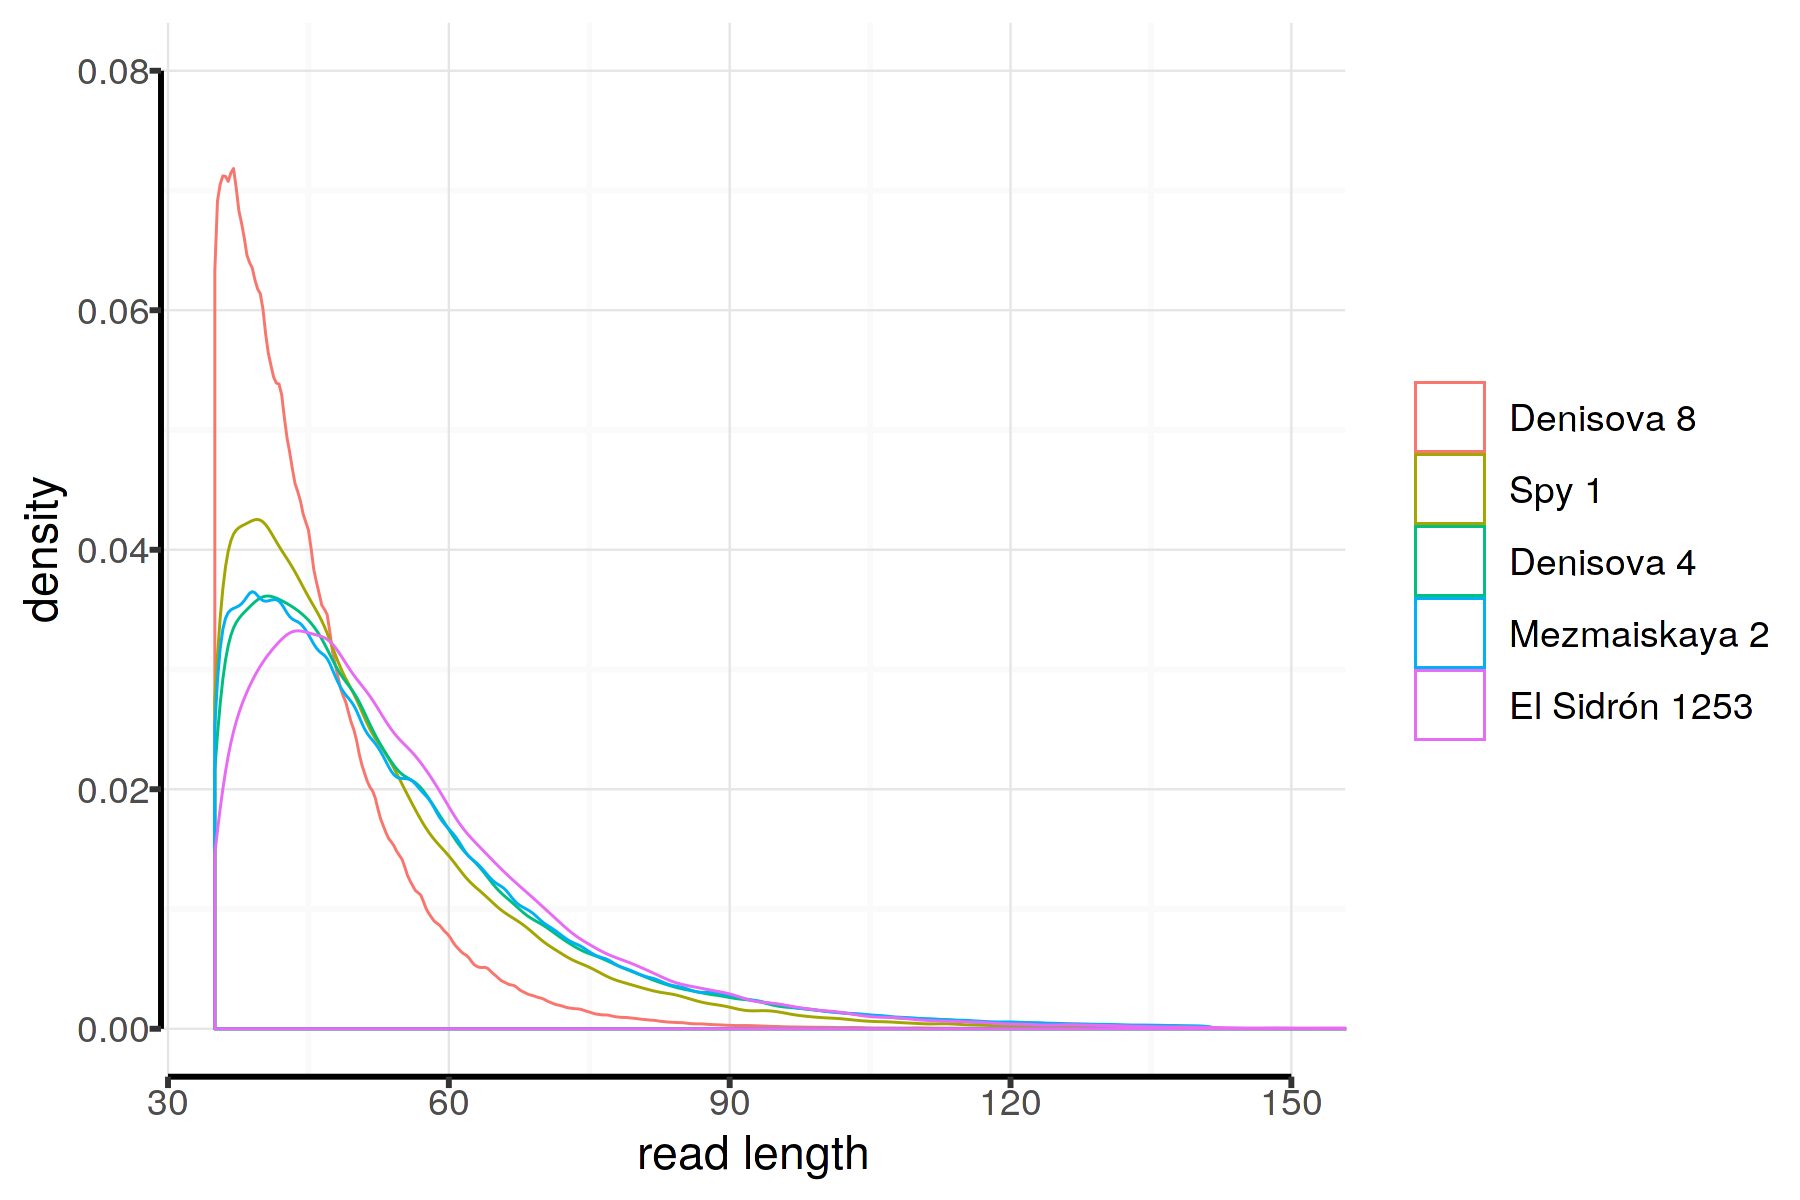

In [14]:
set_dim(6, 4)

length_df %>%
mutate(name = factor(name, levels = summary_df$name)) %>% 
ggplot(aes(length, color = name)) +
    geom_density(size = 0.25) +
    theme_classic() +
    coord_capped_cart(xlim = c(35, 150), ylim = c(0, 0.08), left = "both", bottom = "both") +
    theme(legend.title = element_blank(), plot.title = element_text(size = 12)) +
    background_grid(major = "xy", minor = "xy") +
    xlab("read length")

ggsave(here("figures/read_lengths.png"), width = 6, height = 4)